# Data Preparation

In [1]:
# import necessary libraries to get the data
from nltk.tokenize import sent_tokenize
import pandas as pd
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# in case we need to download NLTK punctuations
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#@title Dataset load for model create
# dataset = pd.read_csv("/content/drive/MyDrive/NER_v2.2/dataset_ner/df_total.csv")
dataset = pd.read_csv("/content/drive/MyDrive/NER_Final/dataset_ner/df_total.csv")
dataset.head()

,title,date,description,source
0,\n Murka Kapolda Metro ke Polisi Jaktim...,"Rabu, 15 Des 2021 05:59 WIB",jakarta timur provos lakukan sidang disiplin t...,www.detik.com
1,\n 2 Anggota Brimob Tersangka Pembunuha...,"Kamis, 26 Mei 2022 10:12 WIB",berkas terduga pelanggar selesai kabid humas p...,www.detik.com
2,\n Cerita Mengerikan Korban KKB Papua S...,"Selasa, 17 Mei 2022 03:00 WIB",ditembak gunung pakai sniper anwar ditemui ked...,www.detik.com
3,\n Guru SD di Bulukumba Dipolisikan Per...,"Senin, 02 Mei 2022 17:29 WIB",laporan pidana pemerkosaan kamaruddin ayah kor...,www.detik.com
4,\n Wanita Tewas Korban Perampokan Sadis...,"Selasa, 15 Mar 2022 15:18 WIB",pelaku inisial pelajar 16 kapolres bone akbp a...,www.detik.com


In [7]:
#@title Flatten dataframe
dataset_list = []

for i in range(0, dataset.shape[0]):
  dataset_list.append(dataset.iloc[i, 2])

print({
      'Data': len(dataset_list)
})

{'Data': 1799}


In [8]:
#@title Join array with space
text_ready = ' '.join(dataset_list[0:40])
# text_ready = ' '.join(dataset_list)
text_ready

'jakarta timur provos lakukan sidang disiplin tuntut mutasi area polda metro jaya fadil rapat gangguan kamtibman polda metro jaya senin 1312 fadil menyayangkan sikap aipda rudi berempati korban perampokan kabid propam awasi sentra pelayanan kepolisian terpadu spkt loket pelayanan masyarakat masyarakat melapor dilayani menyakiti hati masyarakat fadil irwasda kabid propam spktspkt tolong ditertibkan kapolres fadil fadil mengultimatum anggotanya kejadian terulang catat anggota menodai kemurnian profesi kabid propam jajaran tuntut hukuman mutasi area fadil berkas terduga pelanggar selesai kabid humas polda sulsel kombes komang suartana suartana chaerul akmal sulaiman penahanan satreskrim polrestabes makassar diambil alih propam polda sulsel sidang kode etik polri tinggal nunggu sidang kode etik suartana disinggung tepatnya pelaksanaan sidang kode etik polri suartana propam polda sulsel mengajukan permohonan sidang kapolda sulsel irjen nana sudjana tunggu kabid propam mengajukan kapolda kom

# Labelling

In [9]:
annotations = sorted(['nama'])
annotations

['nama']

In [10]:
# install Sastrawi
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.2 MB/s 


In [11]:
#@title Import
from nltk.tokenize import word_tokenize
import itertools
import re
import numpy as np
import string
from tqdm import tqdm

In [12]:
#@title convert_to_spaCyformat
def convert_to_spaCyformat(df, listOfEntities):
    """
    This function is used to convert the BIO-tagged-DF to spaCy format annotations.
    
    Args:
    - df (pandas.DataFrame) > BIO-tagged dataframe consisting of two columns, i.e. token and BIO_tag
    - listOfEntities (list) > list of entities/annotations used
    
    Return:
    - [text, enti] > a list consisting of the text (combined from the tokens) and the interested entities as accordance with spaCy format
    """
    # check if NaN exists
    assert not (df.iloc[:,0].isnull().any() or df.iloc[:,1].isnull().any()), 'The dataset contains nan value.'
    
    # create a dictionary to save the columns of 'token' and 'BIO_tag', and we also define the index of tokens in order
    dictTemp = {}
    dictTemp['token'] = np.array(df.iloc[:,0])
    dictTemp['BIO_tag'] = np.array(df.iloc[:,1].str.lower())
    dictTemp['indices'] = np.array([len(i) for i in dictTemp['token']])

    # first, we need to get the index of the first token
    total_idx = [dictTemp['indices'][0]] 
    temp = dictTemp['indices'][0]
    
    # then we use for loop to count index for each token in cumulative
    for i in range(len(dictTemp['indices'])):
        if i > 0:
            temp += dictTemp['indices'][i]
            total_idx.append(temp)

    # create variable for the start index of each token
    dictTemp['start_idx'] = np.array([total_idx[i-1] if i > 0 else 0 for i in range(len(total_idx))])

    # create variable for the last index of each token
    dictTemp['end_idx'] = np.array(total_idx)
    del dictTemp['indices'] # we no longer need variable indices. then remove it.

    enti = {}
    entities = []
    text = ''.join(dictTemp['token'])
    
    # combine each of listOfEntities with prefix 'b-', 'i-', and 'e-', and add 'o' annotation
    listOfEntities = ['b-'+i.lower() for i in listOfEntities] + \
                     ['i-'+i.lower() for i in listOfEntities] + \
                     ['e-'+i.lower() for i in listOfEntities] + ['o']
    
    # check if each BIO-tag is in listOfEntities
    error_tag = []
    error_boolean = []
    for i in np.unique(dictTemp['BIO_tag']):
        if i in listOfEntities:
            error_boolean.append(True)
        else:
            error_boolean.append(False)
            error_tag.append(i)
    assert all(error_boolean), "Some BIO-tag not listed in listOfEntities arg. {}".format(error_tag)
    
    # fill in entities list with all non 'O' annotations
    for row in range(len(dictTemp['token'])):
        if dictTemp['BIO_tag'][row] != 'o':
            entities.append((dictTemp['start_idx'][row], 
                             dictTemp['end_idx'][row], 
                             dictTemp['BIO_tag'][row]))

    
    start = []
    end = []
    BIO = []
    i = 0
    while i < len(entities):
        try:
            if entities[i][2][2:] == entities[i+1][2][2:]:
                if entities[i][2][0] == 'b':
#                     print('start1', entities[i][0])
                    start.append(entities[i][0])
                    i += 1
                    if entities[i][2][0] == 'e':
#                         print('end1a', entities[i][1])
                        end.append(entities[i][1])
                        BIO.append(entities[i][2][2:])
                        i += 1
                        continue
                    elif entities[i][2][0] == 'i':
                        for j in range(i, len(entities)):
                            if entities[j][2][0] != 'e' and j < len(entities)-1:
#                                 print('sana', entities[j])
                                continue
                            elif entities[j][2][0] == 'e':
#                                 print('end1b', entities[j][1])
                                end.append(entities[j][1])
                                BIO.append(entities[j][2][2:])
                                i = j+1
                                break
                            else:
                                assert 1 == 0, \
                                    "Something error in the BIO-tag you wrote. Error BIO tag: '{}'" \
                                    .format(entities[j][2])
                    elif entities[i][2][0] == 'b':
#                         print('end1b', entities[i-1][1])
                        end.append(entities[i-1][1])
                        BIO.append(entities[i-1][2][2:])
                        continue
                        
#                         print('ss',i,j)
            else:
#                 print('start2a', entities[i][0], i)
                start.append(entities[i][0])
#                 print('end2a', entities[i][1], i)
                end.append(entities[i][1])
                BIO.append(entities[i][2][2:])
                i += 1
        except IndexError:
#             print('start2b', entities[i][0], i)
            start.append(entities[i][0])
#             print('end2b', entities[i][1], i)
            end.append(entities[i][1])
            BIO.append(entities[i][2][2:])
            i += 1

    enti['entities'] = [(i,j,k) for i,j,k in zip(start, end, BIO)]
    return [text, enti]

In [13]:
#@title text_to_tagReadyDF
def text_to_tagReadyDF(input, isCSV=True, more_stopwords=None):
	"""
	This function is used to convert raw text of PUU (either CSV file or pandas Series) into tag-ready dataframe.

	Args:
	- input (pd.Series variable): either CSV file (enter its file location) or pandas Series. If you want to use pandas Series, set 'isCSV' arg to False.
	- isCSV (Boolean): if True, CSV input used. If False, pd.Series input used.
	- more_stopwords (list): add more stopwords if you'd like.

	Return:
	- result dataframe
	"""
    # in case Sastrawi not detected
	try:
		from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
		stopwords = StopWordRemoverFactory().get_stop_words()
	except ModuleNotFoundError:
		print("No module named 'Sastrawi' in your machine. Bypassing 'Sastrawi' dependency, but the number of stopwords will decrease.")
		stopwords = []

	# check input
	if isCSV:
		# add csv file that contains raw PUU texts
		text = pd.read_csv(input, delimiter='|')
		if text.iloc[:,0].dtype == 'O':
			text = text.iloc[:,0]
		else:
			raise ValueError("As 'isCSV' set to True, the 1st column of your CSV file should be the texts you'd like to process.")
			
	else:
		# if pd.Series expected
		if isinstance(input, pd.Series):		# check if data type is suitable
			text = input
		else:
			raise TypeError("As 'isCSV' set to False, 'input' should be a pandas Series.")

	# define punctuation
	punctAndSpace = string.punctuation + ' '
	# kita memerlukan karakter '(', ')', dan '.',
	# karena karakter tsb muncul di ayat dan angka
	punctAndSpace = punctAndSpace.replace('(','')
	punctAndSpace = punctAndSpace.replace(')','')
	punctAndSpace = punctAndSpace.replace('.','')

	# tambah stopwords dari argument variable
	if more_stopwords != None:	
		assert isinstance(more_stopwords, list), "'more_stopwords' arg should be list type."
		stopwords += more_stopwords

	stopwords = sorted(set(stopwords))

	# ubah Raw teks PUU menjadi tokens ke sebuah kolom df
	# lalu beri tagging 'O' secara otomatis pada tokens yang tidak masuk interest annotations
	dfList = []
	for idx, t in tqdm(enumerate(text)):
	    # tokenization
		tokens = [[word_tokenize(w), ','] for w in t.split()]
		print(tokens)
		tokens = list(itertools.chain(*list(itertools.chain(*tokens))))
		tokens = tokens[:-1]

		split_res = []
		for t in tokens:
			# if-else di bawah ini untuk mengcover token berbentuk seperti ini,
			# 'Jakarta-Bogor-Ciawi'
			if re.match(r'\w+\-\w+.*', t):
				line = t.split('-')
				for i,j in enumerate(line):
					split_res.append(j)
					if i < len(line)-1:
						split_res.append('-')
			else:
				split_res.append(t)
	    
	    # membuat tagging 'O' untuk token yang kita anggap tidak masuk list annotations
		# blank = ['' if i.lower() not in list(punctAndSpace) + stopwords else 'O' for i in split_res]
		blank = []
		for i in split_res:
			if i.lower() not in list(punctAndSpace) + stopwords:
				if i in dataset_list:
					blank.append('b-lokasi')
				else:
					blank.append('')
			else: 
				blank.append('O')
		 
		# buat menjadi df
		dfTemp = pd.DataFrame([split_res, blank]).T
		# beri nama kolom sesuai dengan index looping
		dfTemp.columns = ['token_' + str(idx),'BIO_tag_' + str(idx)]
		dfList.append(dfTemp)

	# concat semua df
	df = pd.concat(dfList, axis=1)

	# # save ke file csv yang siap ditag manual
	# df.to_csv(output_loc)
	# print('CSV output file successfully written.')

	return df

In [14]:
# print('barat' in dataset_list)
# print(dataset_list.index('barat'))
# print(dataset_list[2075])
tagready_df = text_to_tagReadyDF(pd.Series([text_ready]), isCSV=False)

0it [00:00, ?it/s]

[[['jakarta'], ','], [['timur'], ','], [['provos'], ','], [['lakukan'], ','], [['sidang'], ','], [['disiplin'], ','], [['tuntut'], ','], [['mutasi'], ','], [['area'], ','], [['polda'], ','], [['metro'], ','], [['jaya'], ','], [['fadil'], ','], [['rapat'], ','], [['gangguan'], ','], [['kamtibman'], ','], [['polda'], ','], [['metro'], ','], [['jaya'], ','], [['senin'], ','], [['1312'], ','], [['fadil'], ','], [['menyayangkan'], ','], [['sikap'], ','], [['aipda'], ','], [['rudi'], ','], [['berempati'], ','], [['korban'], ','], [['perampokan'], ','], [['kabid'], ','], [['propam'], ','], [['awasi'], ','], [['sentra'], ','], [['pelayanan'], ','], [['kepolisian'], ','], [['terpadu'], ','], [['spkt'], ','], [['loket'], ','], [['pelayanan'], ','], [['masyarakat'], ','], [['masyarakat'], ','], [['melapor'], ','], [['dilayani'], ','], [['menyakiti'], ','], [['hati'], ','], [['masyarakat'], ','], [['fadil'], ','], [['irwasda'], ','], [['kabid'], ','], [['propam'], ','], [['spktspkt'], ','], [['tol

1it [00:00,  1.18it/s]


In [15]:
print(tagready_df.shape)
tagready_df

(11035, 2)


,token_0,BIO_tag_0
0,jakarta,
1,",",O
2,timur,
3,",",O
4,provos,
...,...,...
11030,memulihkan,
11031,",",O
11032,korban,
11033,",",O


In [17]:
#@title Safe untagged dataset
link_for_save = "/content/drive/MyDrive/NER_Final/dataset_ner/dataset_untagged2.csv"
tagready_df.to_csv(link_for_save, index=False)
tagready_df

,token_0,BIO_tag_0
0,jakarta,
1,",",O
2,timur,
3,",",O
4,provos,
...,...,...
11030,memulihkan,
11031,",",O
11032,korban,
11033,",",O


hasil text_tagged.csv ku tagging manual di excel. b- (beginning), i- (inside), e- (end)

In [20]:
#@title Load Tagged Dataset
link_BIOtagged_file = "/content/drive/MyDrive/NER_Final/dataset_ner/dataset_tagged2.csv"
df_tagged = pd.read_csv(link_BIOtagged_file)

In [21]:
# print(df_tagged.shape)
df_tagged = df_tagged.fillna('o')
# df_tagged = df_tagged.head(500)
df_tagged

,token_0,BIO_tag_0
0,jakarta,o
1,",",O
2,timur,o
3,",",O
4,provos,o
...,...,...
11030,memulihkan,o
11031,",",O
11032,korban,o
11033,",",O


In [22]:
train_data = convert_to_spaCyformat(df_tagged, annotations)

In [23]:
train_data

['jakarta,timur,provos,lakukan,sidang,disiplin,tuntut,mutasi,area,polda,metro,jaya,fadil,rapat,gangguan,kamtibman,polda,metro,jaya,senin,1312,fadil,menyayangkan,sikap,aipda,rudi,berempati,korban,perampokan,kabid,propam,awasi,sentra,pelayanan,kepolisian,terpadu,spkt,loket,pelayanan,masyarakat,masyarakat,melapor,dilayani,menyakiti,hati,masyarakat,fadil,irwasda,kabid,propam,spktspkt,tolong,ditertibkan,kapolres,fadil,fadil,mengultimatum,anggotanya,kejadian,terulang,catat,anggota,menodai,kemurnian,profesi,kabid,propam,jajaran,tuntut,hukuman,mutasi,area,fadil,berkas,terduga,pelanggar,selesai,kabid,humas,polda,sulsel,kombes,komang,suartana,suartana,chaerul,akmal,sulaiman,penahanan,satreskrim,polrestabes,makassar,diambil,alih,propam,polda,sulsel,sidang,kode,etik,polri,tinggal,nunggu,sidang,kode,etik,suartana,disinggung,tepatnya,pelaksanaan,sidang,kode,etik,polri,suartana,propam,polda,sulsel,mengajukan,permohonan,sidang,kapolda,sulsel,irjen,nana,sudjana,tunggu,kabid,propam,mengajukan,kapolda,ko

# Training

In [24]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from thinc.neural.optimizers import Adam
import random
from matplotlib import pyplot as plt

In [25]:
#@title custom_optimizer
def custom_optimizer(optimizer, learn_rate=0.0001, beta1=0.9, beta2=0.999, eps=1e-8, L2=1e-6, max_grad_norm=1.0):
    """
    Function to customizer spaCy default optimizer
    """
    
    optimizer.learn_rate = learn_rate
    optimizer.beta1 = beta1
    optimizer.beta2 = beta2
    optimizer.eps = eps
    optimizer.L2 = L2
    optimizer.max_grad_norm = max_grad_norm
    
    return optimizer

In [26]:
#@title train_spacy
def train_spacy(data, 
                iterations, 
                learn_rate=0.001, 
                beta1=0.9, 
                beta2=0.999, 
                eps=1e-8, 
                L2=1e-4, 
                max_grad_norm=1.0):
    """Load the model, set up the pipeline and train the entity recognizer."""
    
    # pada dasarnya, steps yang harus dilakukan untuk mentraining model NER di spaCy adalah sbb:
    # 1. instantiate blank model. blank model ini isi tasknya bisa bermacam2. tapi kita hanya butuh task untuk NER
    # 2. karena kita hanya butuh task NER, kita define task (pipe) bernama 'ner'
    # 3. setelah itu, labels yang sudah dipersiapkan di training data diadd ke dalam pipe ner tsb
    # 4. seperti yg disebutkan di poin 1 di atas, task model itu bisa bermacam2. tapi karena kita hanya butuh task NER, makanya task/pipe lain harus kita disable agar tidak ditraining
    # 5. definisikan grad descent optimizer, yaitu menggunakan Adam optimizer. pada method begin_training(), kita bisa mengganti hyperparameters pada model menggunakan arg "component_cfg" yang inputnya berbentuk dict of dicts {'<jenis pipe>': {'<hyperparameter>': value}}. kalau mau tau keys apa saja yg tersedia untuk hyperparameters tsb, setelah model selesai ditraining lalu disave, coba buka folder tempat model disave. lalu di dalam folder tsb, buka folder "ner". di dalam folder "ner", ada file bernama "cfg". file tsb melist semua hyperparameters yg tersedia pada model dan valuesnya.
    # 6. jika kita masih ingin tuning optimizernya, kita bisa menggunakan func custom_optimizer
    # 7. kalau kita mau menggunakan mekanisme dropout, kita bisa menggunakan func "decaying"
    # 8. mulai lakukan iterasi untuk training. iteration = epoch. kita melakukan training sejumlah n epochs. lalu tiap 1 epoch, kita melakukan training sebanyak m minibatches
    # 9. kita menggunakan func minibatch untuk mensplit training data sebanyak x size. func minibatch menerima input arg "size" dalam bentuk iterator, contohnya func compounding yg berfungsi untuk membuat iterator dengan args "start" sebagai nilai awal, "end" sebagai nilai max, dan "compound" sebagai kelipatan untuk dikali dengan nilai pada "Start". baca di sini https://spacy.io/api/top-level#util.minibatch
    # 10. func minibatch akan menghasilkan generator. dari generator tsb, kita melakukan update (forward propagation dan back propagation) pada model menggunakan method update()
    # 11. setelah seluruh minibatches pada 1 epoch/iteration selesai, proses pada epoch berikutnya akan dilakukan. terus seperti itu hingga mencapai epoch terakhir
        
    TRAIN_DATA = data
    nlp = spacy.blank('id')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        
        # additional lines
        optimizer = nlp.begin_training(component_cfg={"ner": {"conv_window": 3}})
        optimizer = custom_optimizer(optimizer, learn_rate=learn_rate)
        # Define decaying dropout
#         dropout = decaying(0.8, 0.2, 1e-6)
        
#         optimizer = nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 64.0, 1.001))
            
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
#                     drop=next(dropout),  # dropout - make it harder to memorise data
                    sgd= optimizer,
                    losses=losses)
            
#             for text, annotations in TRAIN_DATA:
#                 nlp.update(
#                     [text],  # batch of texts
#                     [annotations],  # batch of annotations
#                     drop=next(dropout),  # dropout - make it harder to memorise data
#                     sgd=optimizer,  # callable to update weights
#                     losses=losses)

            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [27]:
# training model
model, loss = train_spacy([train_data], 180)

Starting iteration 0
{'ner': 8453.999725341797}
Starting iteration 1
{'ner': 8124.2960205078125}
Starting iteration 2
{'ner': 6412.736061096191}
Starting iteration 3
{'ner': 3184.7657356262207}
Starting iteration 4
{'ner': 1098.0023956298828}
Starting iteration 5
{'ner': 994.3449468612671}
Starting iteration 6
{'ner': 702.0949735436589}
Starting iteration 7
{'ner': 696.3492414951324}
Starting iteration 8
{'ner': 682.4808726692572}
Starting iteration 9
{'ner': 633.4619719907641}
Starting iteration 10
{'ner': 645.6555891036987}
Starting iteration 11
{'ner': 600.6893375236541}
Starting iteration 12
{'ner': 606.161299158819}
Starting iteration 13
{'ner': 604.2509465408511}
Starting iteration 14
{'ner': 557.0912348330021}
Starting iteration 15
{'ner': 455.3945323857479}
Starting iteration 16
{'ner': 421.3123519420624}
Starting iteration 17
{'ner': 406.3669700026512}
Starting iteration 18
{'ner': 392.3713637292385}
Starting iteration 19
{'ner': 327.1129914522171}
Starting iteration 20
{'ner'

In [28]:
from matplotlib import pyplot as plt

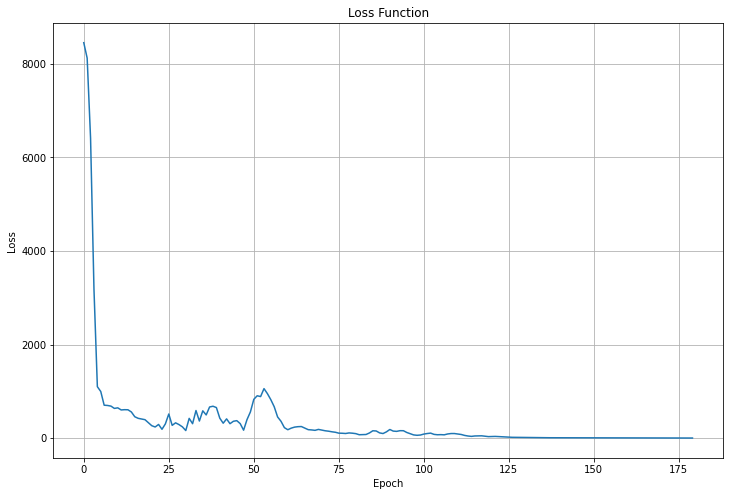

In [29]:
plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
# Save our trained model
link_save_model = "/content/drive/MyDrive/NER_Final/"
modelfile = input("Enter your Model Name: ")
model.to_disk(link_save_model + modelfile)

Enter your Model Name: model_who2
